In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cloudvolume import CloudVolume as cv
from caveclient import CAVEclient
from scipy.spatial import KDTree
import pygsheets
import ast
from collections import Counter, defaultdict
import time
import pickle
from scipy.spatial.distance import cdist
import networkx as nx
import random
from itertools import combinations
import scipy.sparse as sp

vol_graphene =cv('graphene://https://minnie.microns-daf.com/segmentation/table/zheng_ca3', agglomerate=True, use_https=True)
vol = cv('gs://zheng_mouse_hippocampus_production/v2/seg_m195',parallel=True, progress=False, use_https=True)
client = CAVEclient('zheng_ca3')


In [94]:
# load connectivity matrix

syn_thresh = 3
with open('./variables/adjmat_and_bouton_thorn_dist_matrix_250707_th' +str(syn_thresh)+'.pkl','rb') as f:
    adj_mat_weighted, mf_ids, pc_ids, coord_df, d_mat, syn_df = pickle.load(f)
adj_mat = (adj_mat_weighted != 0).astype(int)


In [95]:
# Find all pairs of pyr cells that share at least two common MFs from the real(observed) data matrix

pyr_pairs = []
shared_mfs = []

for idx_pyr1, idx_pyr2 in combinations(range(len(pc_ids)),2):
    common_mf_indices = np.where((adj_mat[idx_pyr1,:] > 0) & (adj_mat[idx_pyr2,:] > 0))[0]
    common_mfs = []
    if len(common_mf_indices) >= 2:
        for i in range(len(common_mf_indices)):
            common_mfs.append(mf_ids[common_mf_indices[i]])
        common_mfs = list(set(common_mfs))
        if len(common_mfs) >= 2:
        #print(f"Pyr pair ({pc_ids[idx_pyr1]}, {pc_ids[idx_pyr2]}) shares MFs: {common_mfs}")
            pyr_pairs.append([pc_ids[idx_pyr1], pc_ids[idx_pyr2]])
            shared_mfs.append(common_mfs)

num_shared_MFs = [len(sublist) for sublist in shared_mfs]
freq_num_shared_MFs = Counter(num_shared_MFs)
print(freq_num_shared_MFs)

Counter({2: 246, 3: 22, 4: 8, 5: 6, 7: 2, 6: 1, 8: 1})


In [96]:
print(client.materialize.get_versions())
for version in client.materialize.get_versions():
    print(f"Version {version}: {client.materialize.get_timestamp(version)}")

[1, 195, 316, 313, 314, 315]
Version 1: 2024-08-16 03:02:50.468339+00:00
Version 195: 2025-02-26 10:10:01.468822+00:00
Version 316: 2025-07-01 13:10:01.257067+00:00
Version 313: 2025-06-28 13:10:01.285136+00:00
Version 314: 2025-06-29 13:10:01.310954+00:00
Version 315: 2025-06-30 13:10:01.380239+00:00


In [19]:
# correlation of the shared-MF-input synapses

syn_sizes1 = []
syn_sizes2 = []
d_between_two_syn = []
color7 = ['xx','blue','green','red','yellow','purple','cyan','magenta']
colors = []

data_numMF_shared = []
data_dist_btwn_two_syn = []
for i in range(len(pyr_pairs)):
    print(i, '/', len(pyr_pairs))
    syn_df = client.materialize.synapse_query(pre_ids=shared_mfs[i], post_ids=pyr_pairs[i], bounding_box=None, bounding_box_column='post_pt_position', 
                timestamp=tstamp, remove_autapses=True, include_zeros=False, limit=None, offset=None, 
                split_positions=False, desired_resolution=[1000,1000,1000], materialization_version=None, 
                synapse_table='synapses_ca3_v1', datastack_name='zheng_ca3', metadata=True) 
    df_pc1 = syn_df[syn_df['post_pt_root_id'] == pyr_pairs[i][0]]
    df_pc2 = syn_df[syn_df['post_pt_root_id'] == pyr_pairs[i][1]]
    
    for j in range(len(shared_mfs[i])):
        df_temp = df_pc1[df_pc1['pre_pt_root_id']==shared_mfs[i][j]]
        if len(df_temp) == 0:
            print('do not have synapses')
        df_temp2 = df_pc2[df_pc2['pre_pt_root_id']==shared_mfs[i][j]]
        if len(df_temp2) == 0:
            print('do not have synapses')
            
        syn_center1 = df_temp['ctr_pt_position'].values.mean()
        syn_center2 = df_temp2['ctr_pt_position'].values.mean()
        d = np.linalg.norm(syn_center1 - syn_center2)
        
        data_numMF_shared.append(len(shared_mfs[i]))
        data_dist_btwn_two_syn.append(d)
        
        
        if d >= 100:
            d_between_two_syn.append(np.linalg.norm(syn_center1 - syn_center2))
            syn_sizes1.append(sum(df_temp['size'].values))
            syn_sizes2.append(sum(df_temp2['size'].values))
            #syn_sizes1.append(len(df_temp['size'].values))
            #syn_sizes2.append(len(df_temp2['size'].values))
            colors.append(color7[len(shared_mfs[i])-1])
        
    

0 / 277
1 / 277
2 / 277
3 / 277
4 / 277
5 / 277
6 / 277
7 / 277
8 / 277
9 / 277
10 / 277
11 / 277
12 / 277
13 / 277
14 / 277
15 / 277
16 / 277
17 / 277
18 / 277
19 / 277
20 / 277
21 / 277
22 / 277
23 / 277
24 / 277
25 / 277
26 / 277
27 / 277
28 / 277
29 / 277
30 / 277
31 / 277
32 / 277
33 / 277
34 / 277
35 / 277
36 / 277
37 / 277
38 / 277
39 / 277
40 / 277
41 / 277
42 / 277
43 / 277
44 / 277
45 / 277
46 / 277
47 / 277
48 / 277
49 / 277
50 / 277
51 / 277
52 / 277
53 / 277
54 / 277
55 / 277
56 / 277
57 / 277
58 / 277
59 / 277
60 / 277
61 / 277
62 / 277
63 / 277
64 / 277
65 / 277
66 / 277
67 / 277
68 / 277
69 / 277
70 / 277
71 / 277
72 / 277
73 / 277
74 / 277
75 / 277
76 / 277
77 / 277
78 / 277
79 / 277
80 / 277
81 / 277
82 / 277
83 / 277
84 / 277
85 / 277
86 / 277
87 / 277
88 / 277
89 / 277
90 / 277
91 / 277
92 / 277
93 / 277
94 / 277
95 / 277
96 / 277
97 / 277
98 / 277
99 / 277
100 / 277
101 / 277
102 / 277
103 / 277
104 / 277
105 / 277
106 / 277
107 / 277
108 / 277
109 / 277
110 / 277


In [ ]:
# ext data fig 5b

plt.rcParams.update({'font.size': 14})    
plt.figure(figsize=(7,7))
plt.grid(True)
plt.scatter(syn_sizes1, syn_sizes2, s=12, color=colors, alpha=0.9)
plt.title('d >100 um')
plt.xlabel('MF syn size onto pyr 1')
plt.ylabel('MF syn size onto pyr 2')
plt.gca().set_aspect("equal")
#plt.xlim([0,70])
#plt.ylim([0,70])

plt.figure(figsize=(5,5))
plt.hist(d_between_two_syn,20)
plt.xlabel('Distance between two syn (um)')
plt.ylabel('Number of syn pairs')


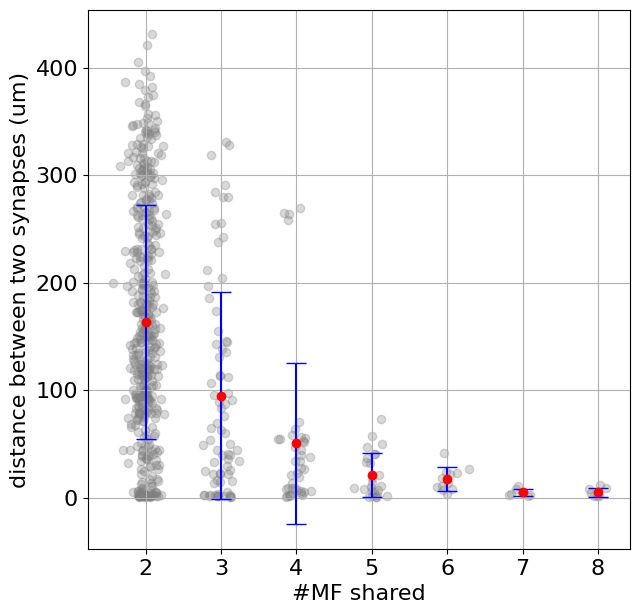

/var/folders/1z/xkdg4p4s67b2m3d28t5knz700000gq/T/ipykernel_98134/4239831352.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='numMF',y='d', data=df, inner=None, width=0.8, palette='pastel')


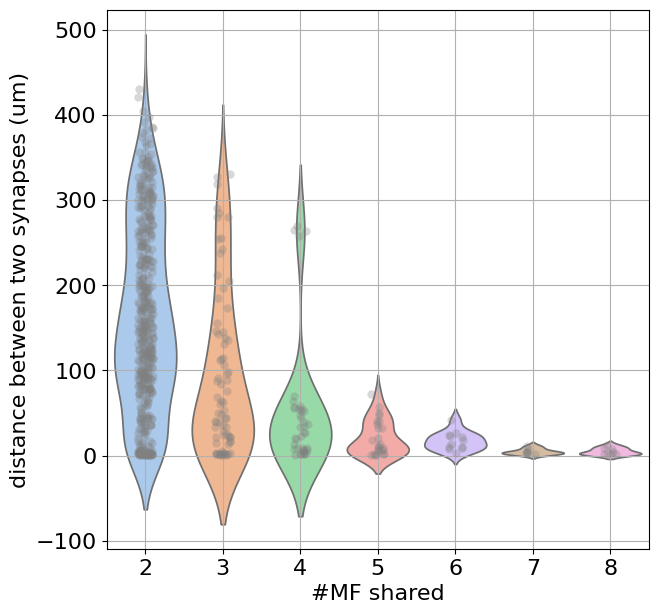

In [21]:
# ext data fig 5c

plt.rcParams.update({'font.size': 16})    
plt.figure(figsize=(7,7))
plt.grid(True)
df = pd.DataFrame({'numMF':data_numMF_shared,'d':data_dist_btwn_two_syn})
grouped = df.groupby('numMF')['d'].agg(['mean','std']).reset_index()
x_jittered = df['numMF'] + np.random.normal(0, 0.1, size=len(df))
plt.scatter(x_jittered, df['d'], alpha=0.3, color='gray', label='Individual Points')
plt.errorbar(grouped['numMF'], grouped['mean'], yerr=grouped['std'], ecolor='blue',mfc='red',mec='red',fmt='o', capsize=7)
plt.xlabel("#MF shared")
plt.ylabel('distance between two synapses (um)')
plt.show()

import seaborn as sns
plt.figure(figsize=(7,7))
sns.violinplot(x='numMF',y='d', data=df, inner=None, width=0.8, palette='pastel')
sns.stripplot(x='numMF',y='d', data=df, size=6, jitter=0.1, color='gray',alpha=0.3)
plt.xlabel("#MF shared")
plt.ylabel('distance between two synapses (um)')
plt.grid(True)
plt.show()